In [8]:
using Revise
import JLD
import PyCall
import CMF
import PyPlot; plt = PyPlot

include("./plot_settings.jl");

## Load data

Spectrogram from a singing bird. Dataset from:

Mackevicius, E. L., Bahle, A. H., Williams, A. H., Gu, S., Denisenko, N. I., Goldman, M. S., & Fee, M. S. (2019). Unsupervised discovery of temporal sequences in high-dimensional datasets, with applications to neuroscience. *eLife*, 8, e38471.

Available at https://github.com/FeeLab/seqNMF

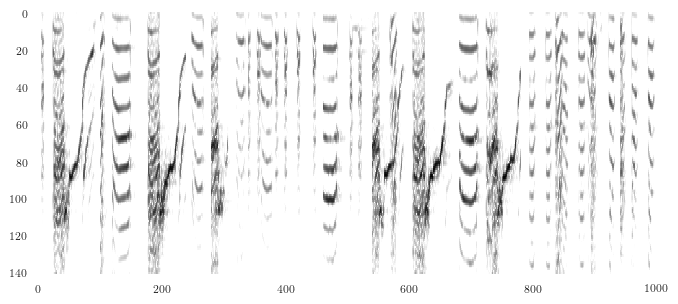

In [2]:
scipy_io = PyCall.pyimport("scipy.io")
matfile = scipy_io.loadmat("../../cmf_data/MackeviciusData.mat")
song = matfile["SONG"]

plt.imshow(song[:, 1000:2000], aspect=3)
plt.grid(false)
plt.show()

## Fit algorithms

In [3]:
L = 50
K = 3

algorithms = Dict(
    "HALS" => :hals,
    "Mult" => :mult,
    "ANLS" => :anls
)
max_time = 60
seed = sum([Int(c) for c in "INITIALIZE"]);



In [4]:
res = Dict()

# Warmstart algorithms
for alg in keys(algorithms)
    CMF.fit_cnmf(
        song, K=K, L=L,
        alg=algorithms[alg], max_itr=1, max_time=Inf
    )
end
println("Finished warmstart")

for alg in keys(algorithms)
    res[alg] = CMF.fit_cnmf(
        song, K=K, L=L,
        alg=algorithms[alg], max_itr=Inf, max_time=max_time, seed=seed
    )
    
    println("Finished ", alg)
end

Finished warmstart
Finished ANLS
Finished HALS
Finished Mult


In [5]:
JLD.save("songbird.jld", res)

## Plot results

In [6]:
res = JLD.load("songbird.jld");

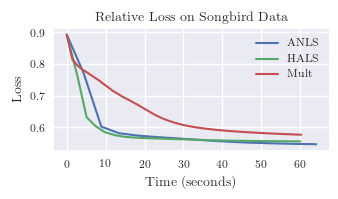

In [9]:
# Plot loss curves

fig, ax = plt.subplots(figsize=set_size(doc_columnwidth; aspect=0.6))

for alg in keys(res)
    ax.plot(res[alg].time_hist, res[alg].loss_hist, label=alg,
            marker=nothing, markersize=0)
end

ax.set_xlabel("Time (seconds)")
ax.set_ylabel("Loss")
ax.legend()
ax.set_title("Relative Loss on Songbird Data")

plt.tight_layout()
plt.savefig("./songbird.pdf", format="pdf")
plt.show()

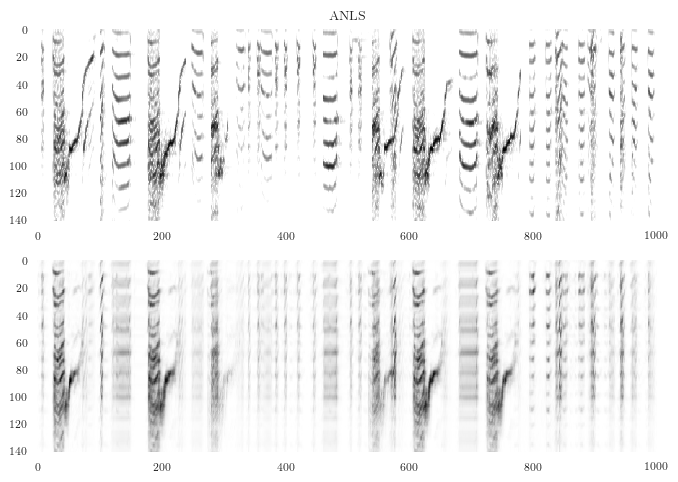

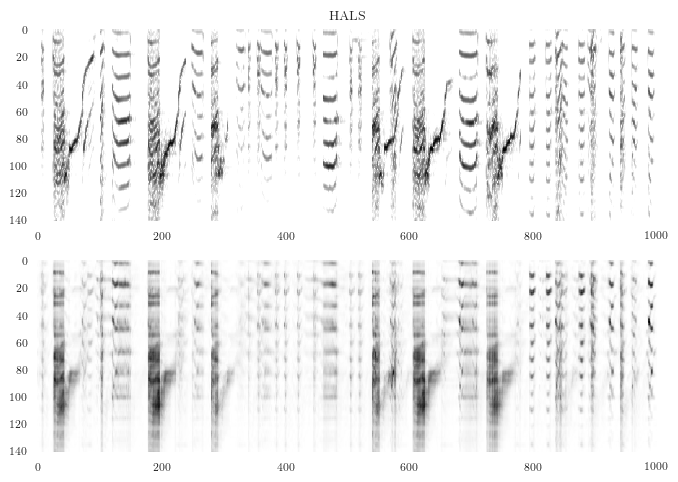

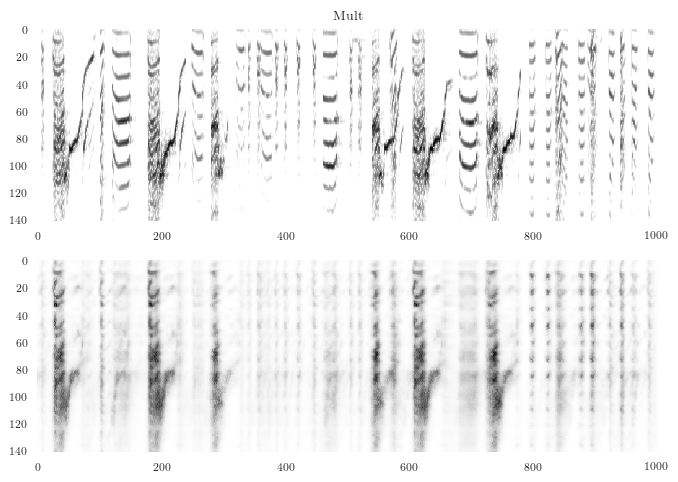

In [8]:
# Visually verify integrity of reconstructions

for alg in keys(res)
    fig, axes = CMF.plot_reconstruction(res[alg], 1000:2000, sort_units=false)
    axes[1].set_title(alg)
    plt.show()
end